# 빅데이터를 이용한 철로사고방지 예측 서비스

## 철도 선로 이미지데이터(샘플)

* 샘플데이터를 보면, 구간별로 연속적인 사진의 형태로 보여짐

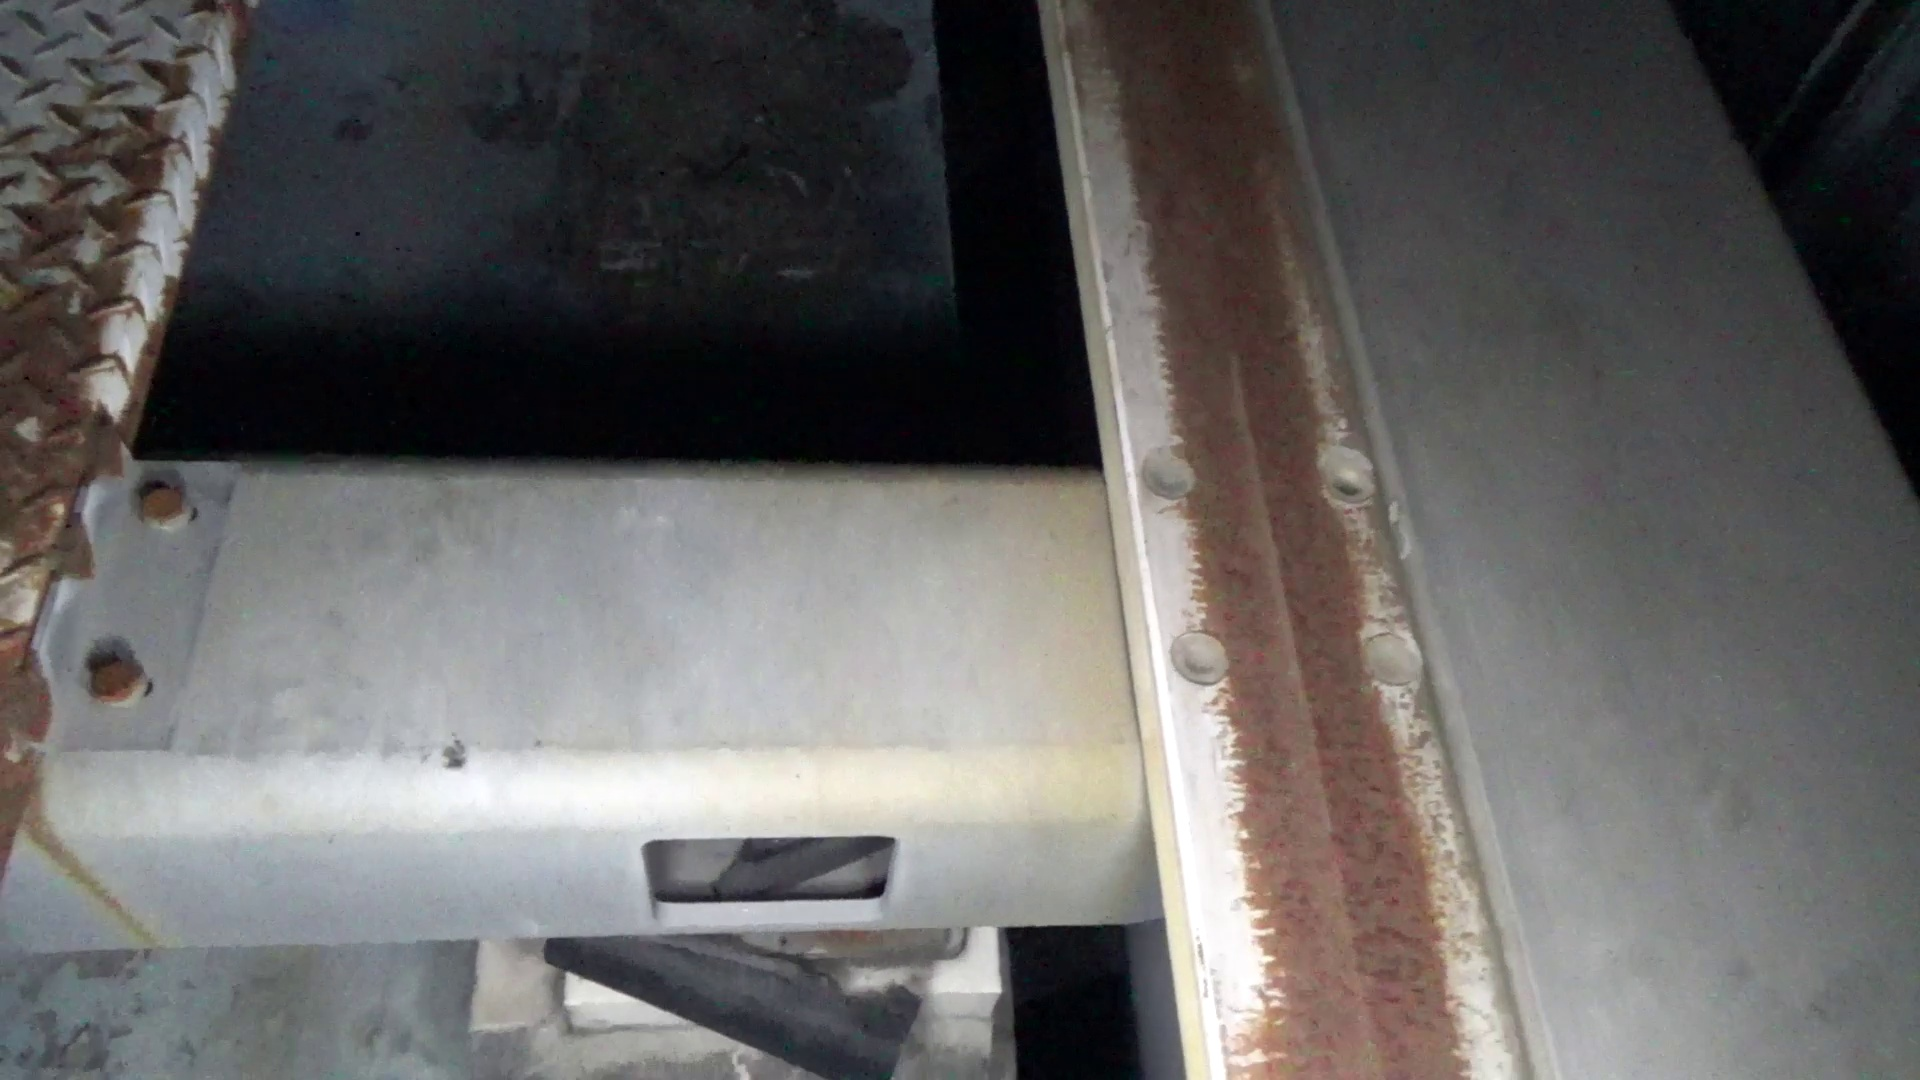

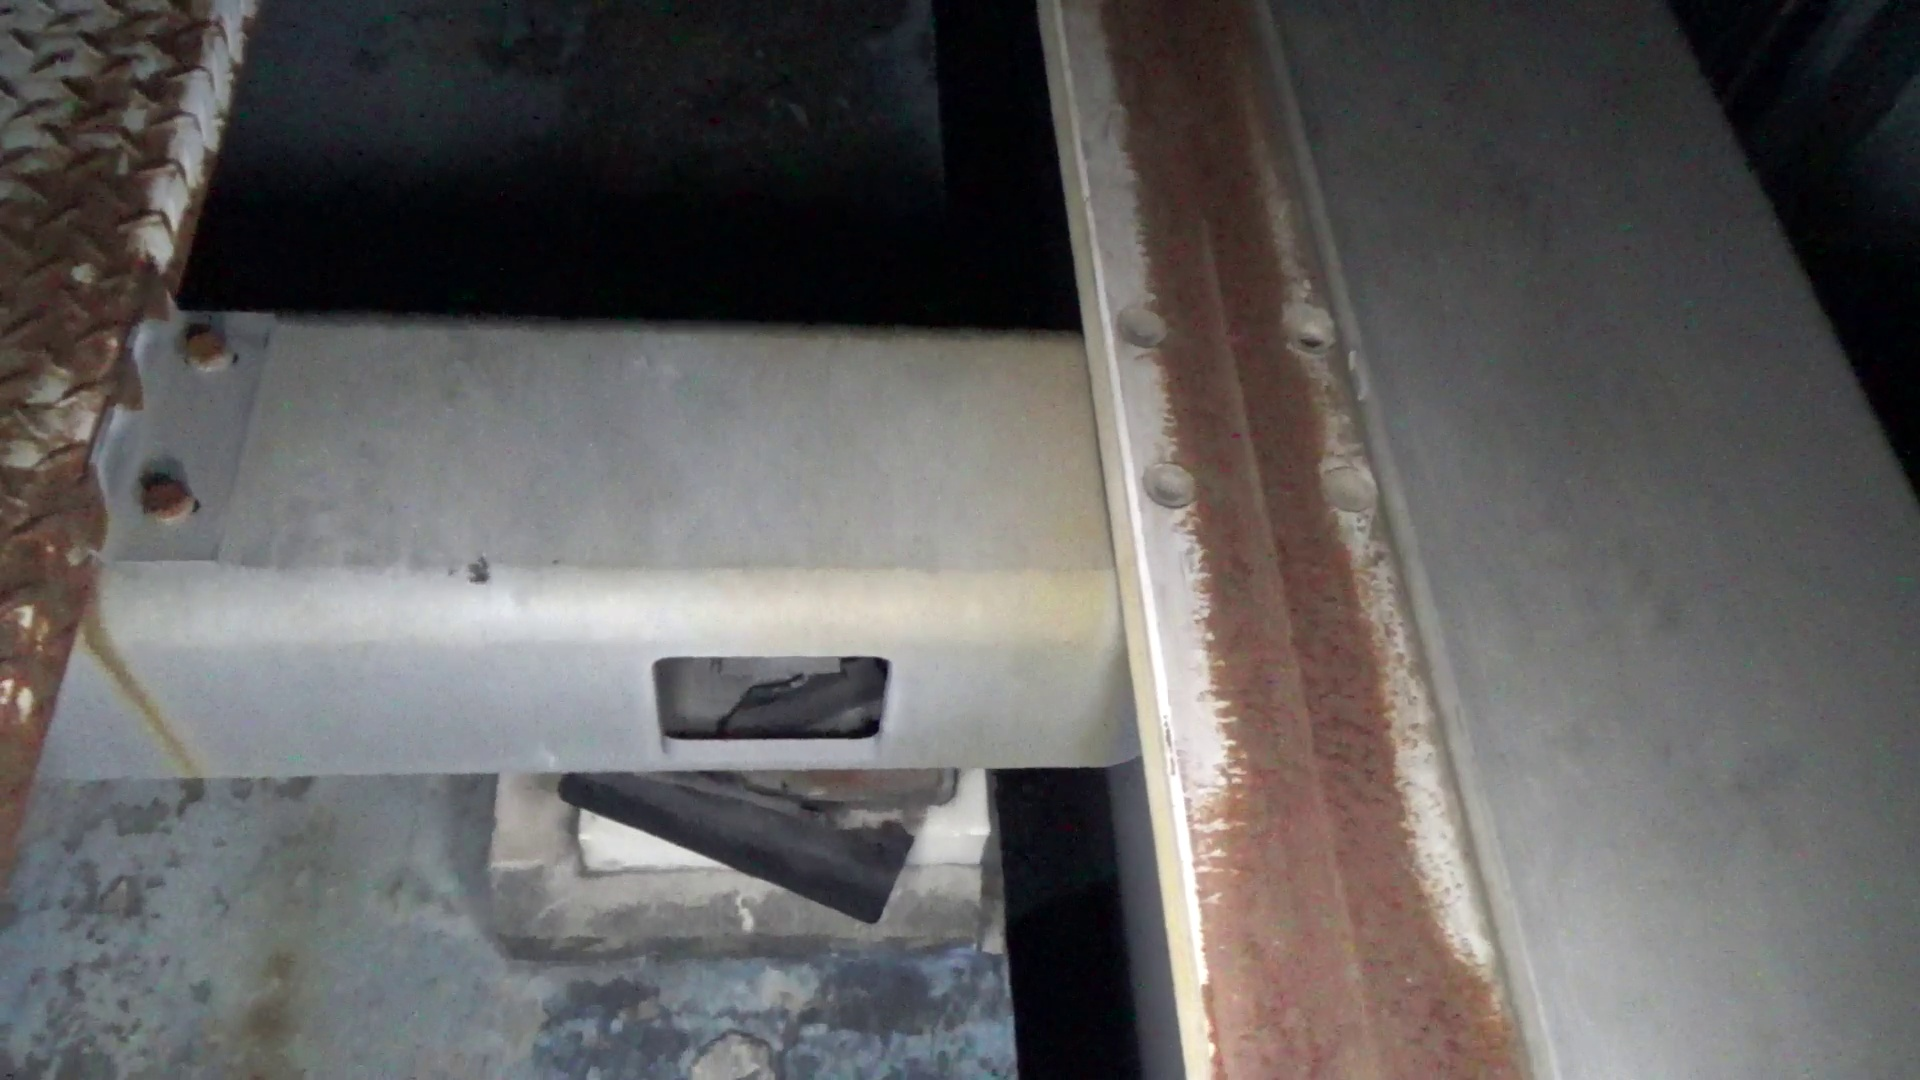

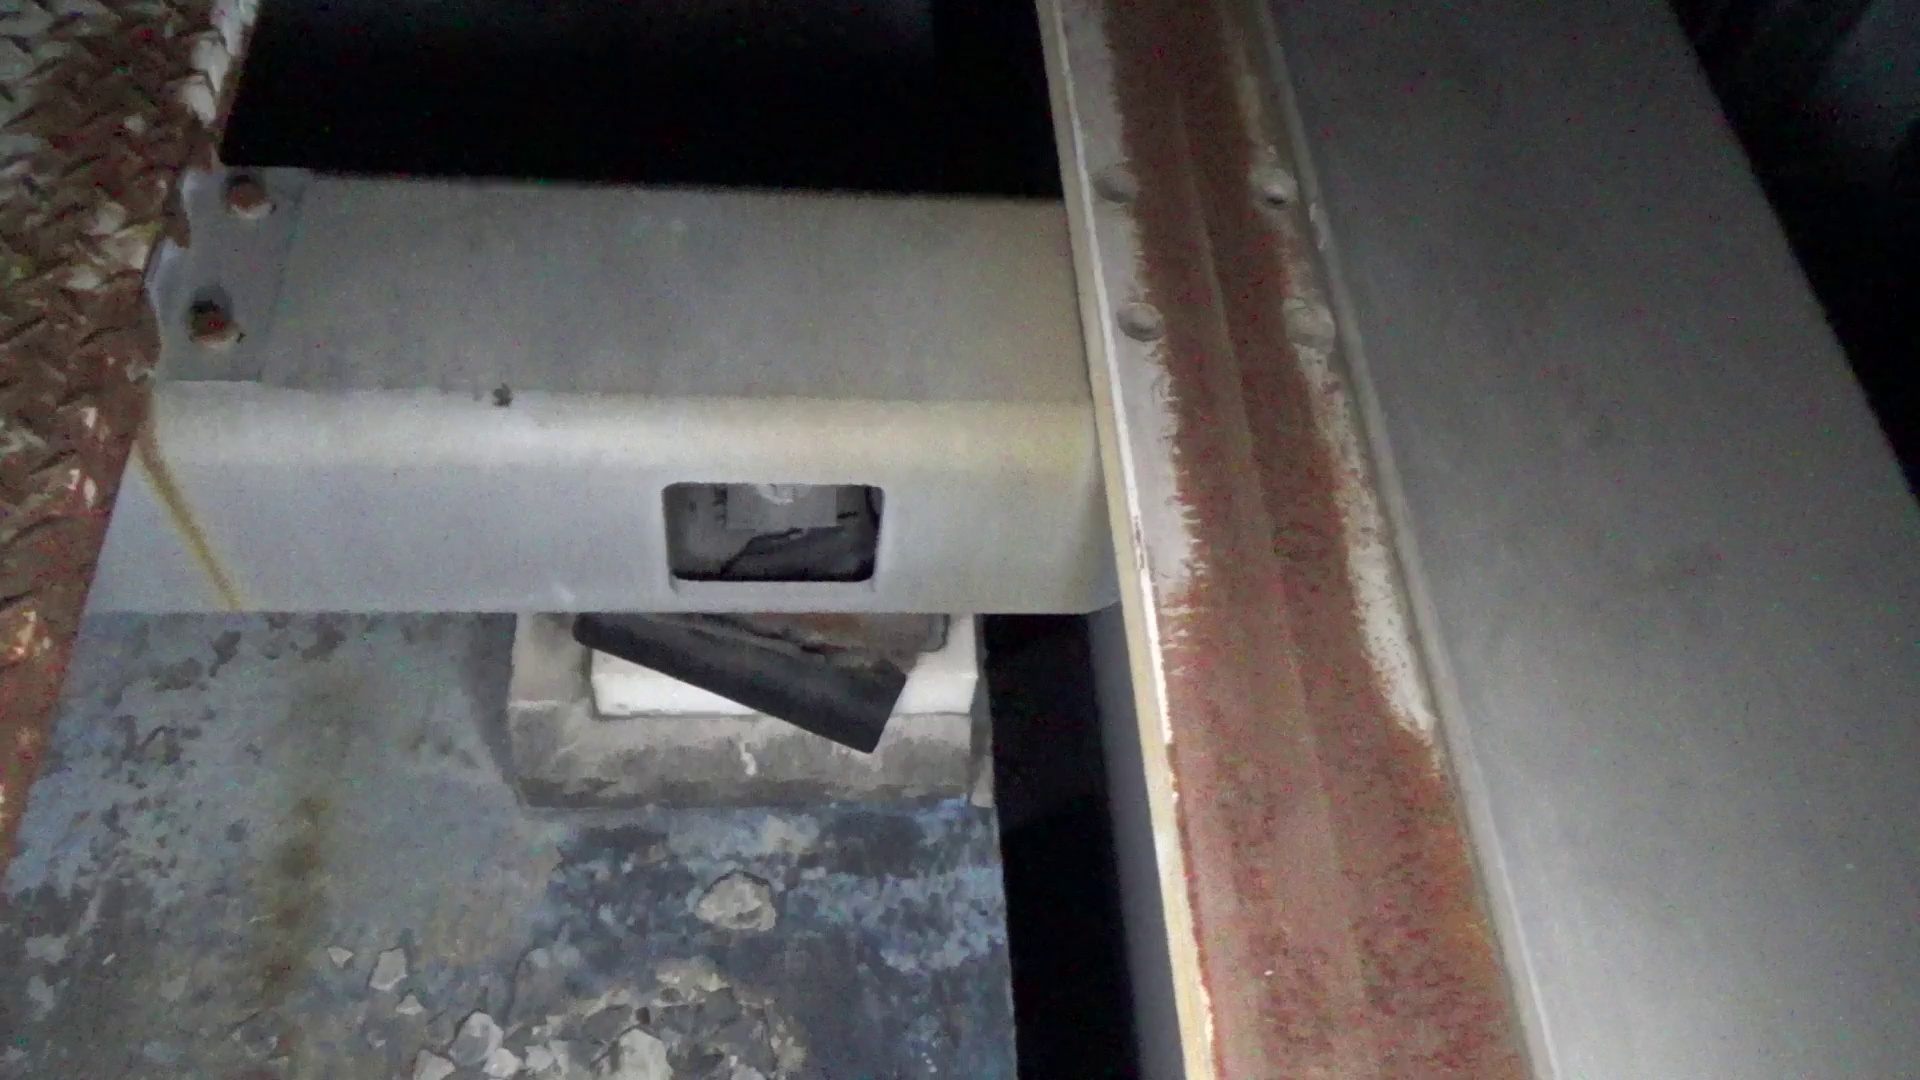

* 참고 블로그: https://ssong915.tistory.com/43

## 객체 탐지 모델

### 사용 및 평가 지표
* 참고: https://eehoeskrap.tistory.com/546
* 참고: https://www.waytoliah.com/1491

### IoU (Intersection Over Union)
* 두 경계 상자간의 겹침을 평가하는 Jaccard Index 를 기반으로 하는 측정 기법
* 두 경계 상자간이라는 것은 GT 박스와 검출된(예측된) 박스를 뜻한다.
* IoU 를 적용하면 탐지 결과가 유효한지 아닌지를 알 수 있다.

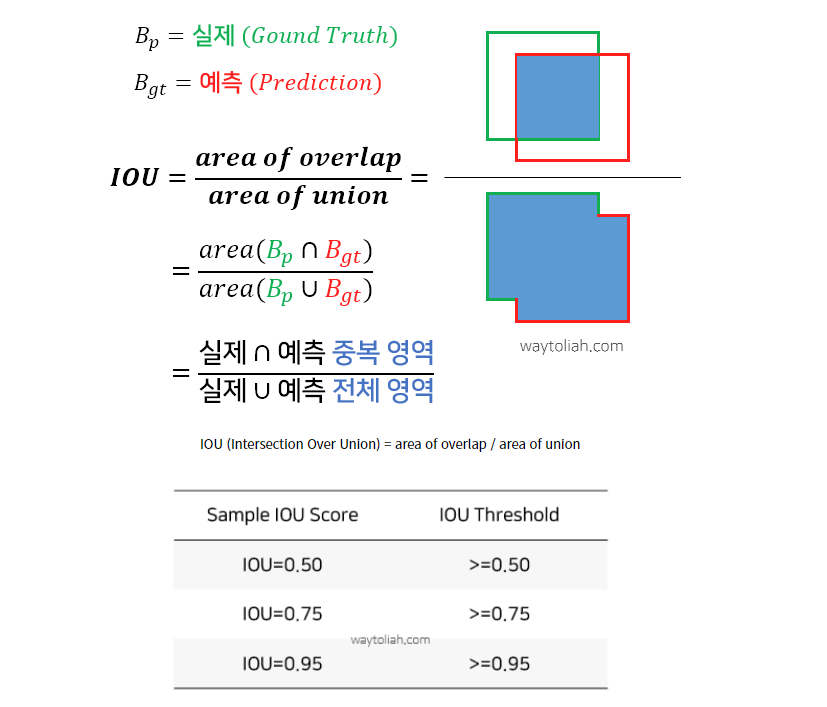

### Precision & Recall

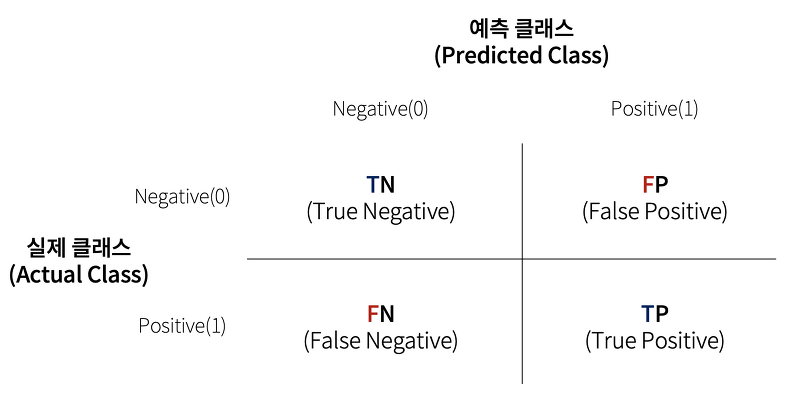

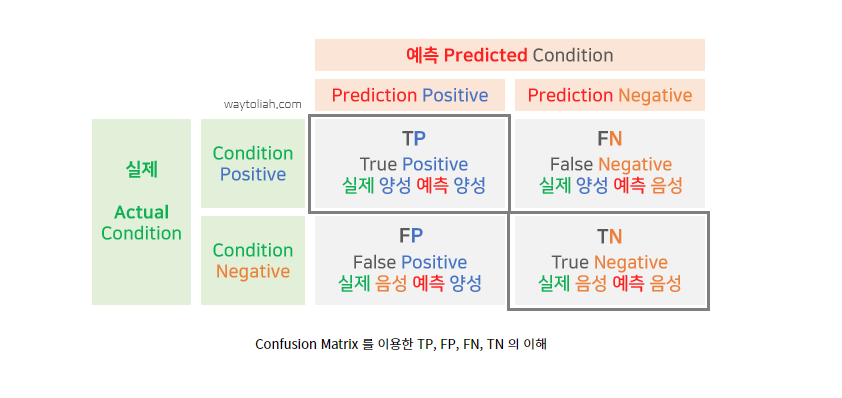

* **True Positive(TP)**: 모델이 '참'이라고 예측했는데 실제값도 '참'인 경우(긍정 예측, 참), IOU >= Threshold
* **False Positive(FP)**: 모델이 '참'이라고 예측했는데 실제값은 '거짓'인 경우(긍정 예측, 거짓), IOU < Threshold
* **False Negative(FN)**: 모델이 '거짓'이라고 예측했는데 실제값은 '참'인 경우(부정 예측, 거짓) -> Type2오류(2종 오류), Ground Truth를 아예 detect 못함
* **True Negative(TN)**: 모델이 '거짓'으로 예측했는데 실제값도 '거짓'인 경우(부정 예측, 참)

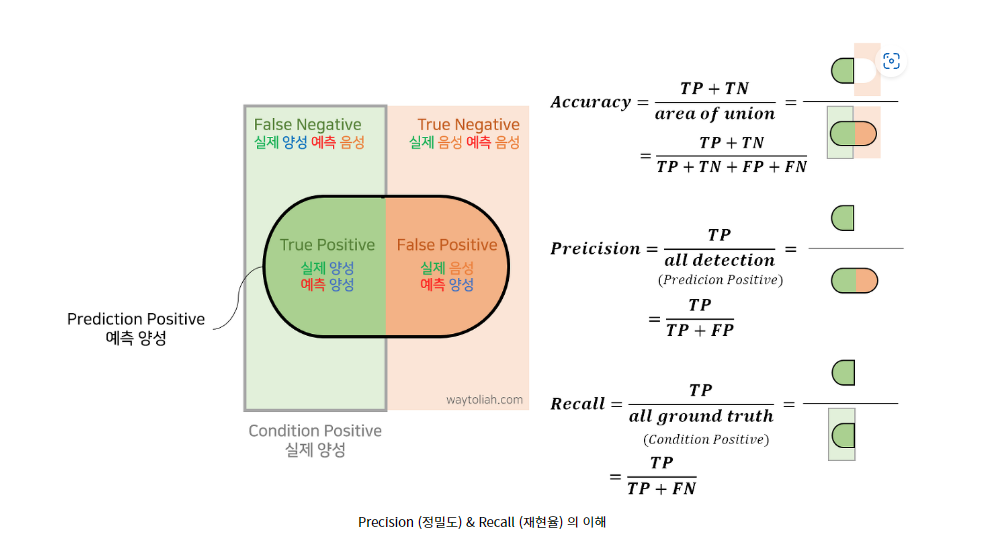

* 재현율과 정밀도의 트레이드-오프관계

### AP (Average Precision) 와 mAP (mean Average Precision)
* AP: Recall 을 0부터 0.1 단위로 증가시켜서 1까지 (총 11개의 값) 증가 시킬 때 필연적으로 Precision 이 감소하게 되는데 각 단위 마다 Precision 값을 계산하여 평균을 내어 계산한다. 즉 11가지의 Recall 값에 따른 Precision 값들의 평균을 말함
* mAP: 하나의 클래스 마다 AP 값을 계산 할 수 있으며 전체 클래스 갯수에 대해 AP를 계산하여 평균을 낸 값

## 사용가능한 딥러닝 모델

* 크게 Yolov5와 Mask R-CNN로 나뉠 듯함

## 1. Yolov5(바운딩박스 기반)

* You Only Look Once 의 약자로 Object detection 분야(객체 탐지)에서 많이 알려진 모델
* 현재는 yolov8까지 업데이트 되는 딥러닝 알고리즘이 나옴

* yolov5 깃허브: https://github.com/ultralytics/yolov5

### 특징
1. 이미지 전체를 한번만 본다
    - R-CNN모델의 경우 이미지를 여러장으로 분할하고 CNN 모델을 이용하여 이미지를 분석함. 따라서 이미지 한장을 보더라도 여러장의 이미지를 분석하는 것과 같다. 하지만 YOLO는 이러한 과정없이 이미지를 한 번만 보는 특징을 가지고 있다.
2. 통합된 모델 사용
    - 기존 Object Detection 모델은 전처리모델 + 인공신경망 을 결합하여 사용했다. 하지만 YOLO에서는 위를 통합한 모델을 사용
3. 실시간으로 객체를 탐지할 수 있는 것
    - 기존의 R-CNN보다 약 6배 빠른 성능

### 장점

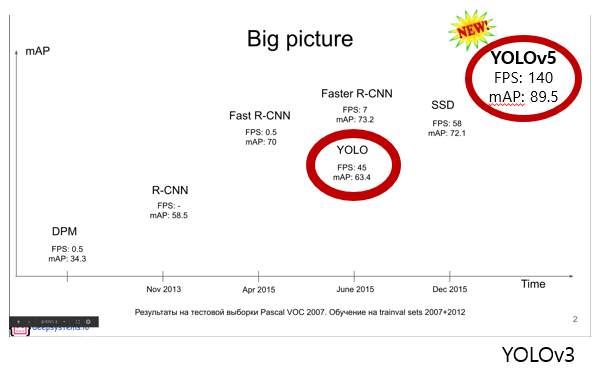

* 간단한 처리 과정으로 속도가 매우 빠르며 기존의 실시간 Object Detection 모델들과 비교하면 2배 정도 높은 mAP를 보인다
* 이미지 전체를 한 번에 바라보는 방식을 이용하므로 class에 대한 맥락적 이해도가 다른 모델에 비해 높아 낮은 False-Positive를 보인다.
* 일반화된 Object 학습이 가능하여 자연 이미지로 학습하고 이를 그림과 같은 곳에 테스트 해도 다른 모델에 비해 훨씬 높은 성능을 보여준다.

### 단점

* 다른 모델에 비해 낮은 정확도를 가진다. 특히, 작은 객체에 대해 정확도가 낮다. 

### 객체 탐지 알고리즘의 구조

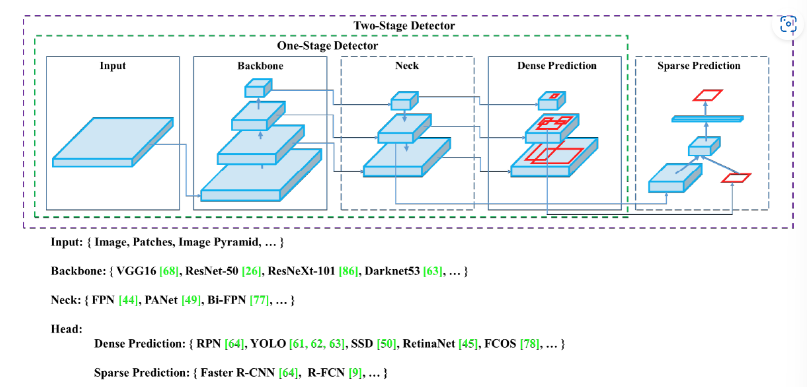

* 최신 detector는 주로 백본과 헤드라는 두 부분으로 구성
* **백본**: 입력이미지를 feature map으로 변형시켜주는 부분
* **헤드**:  Backbone에서 추출한 feature map의 location 작업을 해주는 부분, predict classes 와 bounding boxes 작업이 수행됨, 헤드는 크게 Dense Prediction과 Sparse Prediction으로 나누어짐
* **넥**:  Backbone 과 Head를 연결하는 부분, feature map을 정제하고 재구성

### 딥러닝 절차

input(이미지) -> CNN -> FC(Fully Connected) -> PT(Prediction Tensor)의 과정 반복

1. 이미지를 S * S의 그리드로 분할(예시그림에서는 7*7)<br>
* 그리드마다 하나의 객체를 예측. 미리 설정해둔 경계를 통해 객체의 위치와 크기를 파악. 여러 객체가 한 셀에 있으면 탐지를 못할 수도 있음
* 각 Grid Cell은 아래의 조건이 있다.
* B개의 boundary boxes를 예측하고, 각 box는 하나의 box condfidence score를 가지고 있다.
    - 예측된 box 수에 관계 없이 단 하나의 객체만 탐지
    - boundary box는 객체의 위치 (x,y), 객체의 크기 (w,h), box confidence score로 구성
    - box confidence score는 box가 객체를 포함하고 있을 가능성을 반영
* C개의 conditional class probabilities를 예측
    - 탐지된 객체가 어느 특정 클래스에 속하는 지에 대한 확률

2. 이미지 전체를 신경망에 넣고 특징 추출을 통해 예측 텐서(Prediction Tensor) 생성
- S * S * (B * 5 + c)
- 7x7 grids, 2 boundary boxes, 20 classes = 7 * 7 * 30
- YOLO는 7730 텐서를 예측하는 CNN 네트워크를 구축해야함

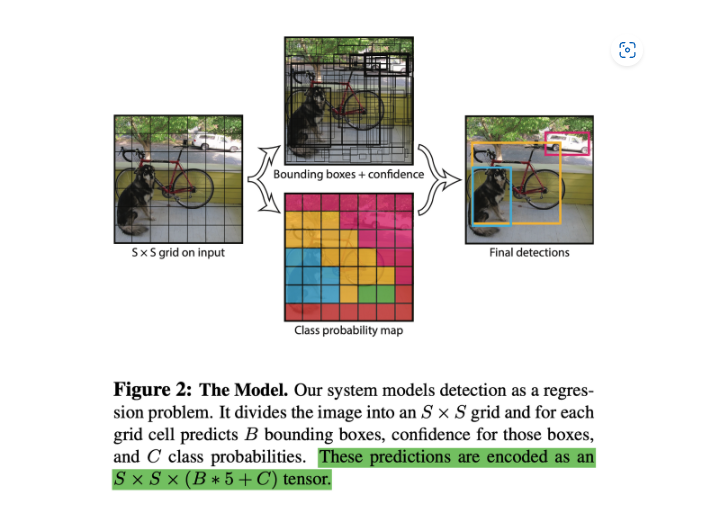

## 2. Mask R-CNN(세그멘테이션 기반)

* 참고사이트: https://herbwood.tistory.com/20

* Mask R-CNN은 일반적으로 detection task보다는 instance segmentation task에서 주로 사용
* Faster R-CNN에 기반한 모델

### Instance segentation

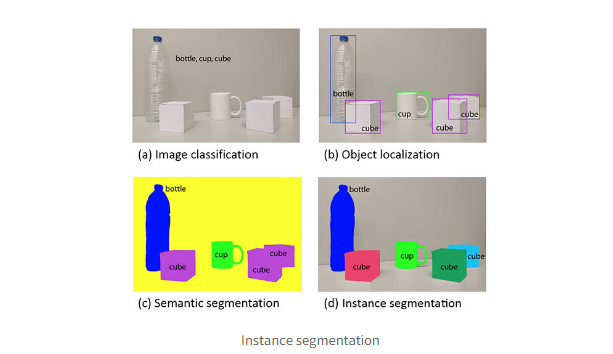

* 이미지 내에 존재하는 모든 객체를 탐지하는 동시에 각각의 경우(instance)를 정확하게 픽셀 단위로 분류하는 task
* Semantic segmentation이 동일하게 분류된 카테고리의 instance를 구분하지 않는다는 점에서 차이가 있다.
* 객체를 탐지하는 object detection task와 각각의 픽셀의 카테고리를 분류하는 semantic segmentation task가 결합된 것이라 이해하면 됨

### Mask R-CNN의 구조

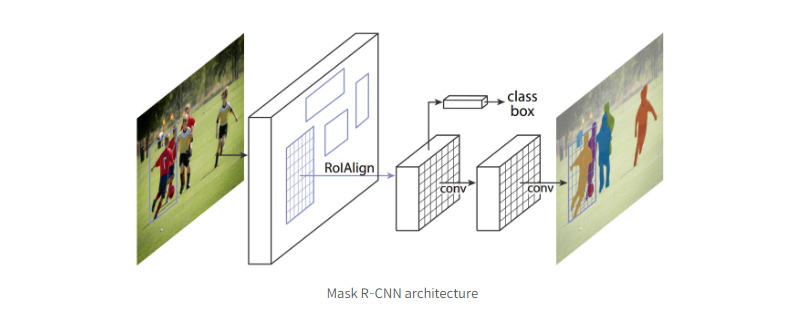

* Faster R-CNN의 RPN에서 얻은 RoI(Region of Interest)에 대하여 객체의 class를 예측하는 classification branch, bbox regression을 수행하는 bbox regression branch와 평행으로 segmentation mask를 예측하는 mask branch를 추가한 구조
* mask branch는 각각의 RoI에 작은 크기의 FCN(Fully Convolutional Network)가 추가된 형태
* segmentation task를 보다 효과적으로 수행하기 위해 논문에서는 객체의 spatial location을 보존하는 RoIAlign layer를 추가함

## 3. R-CNN

* 참고사이트: https://wikidocs.net/148633

* 'Regions with Convolutional Neuron Networks features'의 약자로, 즉 설정한 Region을 CNN의 feature(입력값)로 활용하여 Object Detection을 수행하는 신경망을 뜻함
* CNN을 이용한 검출 방식이 Classification 뿐만 아닌 Object Detection 분야에도 높은 수준의 성능을 이끌어 낼 수 있다는 것을 보여준 의미 있는 모델

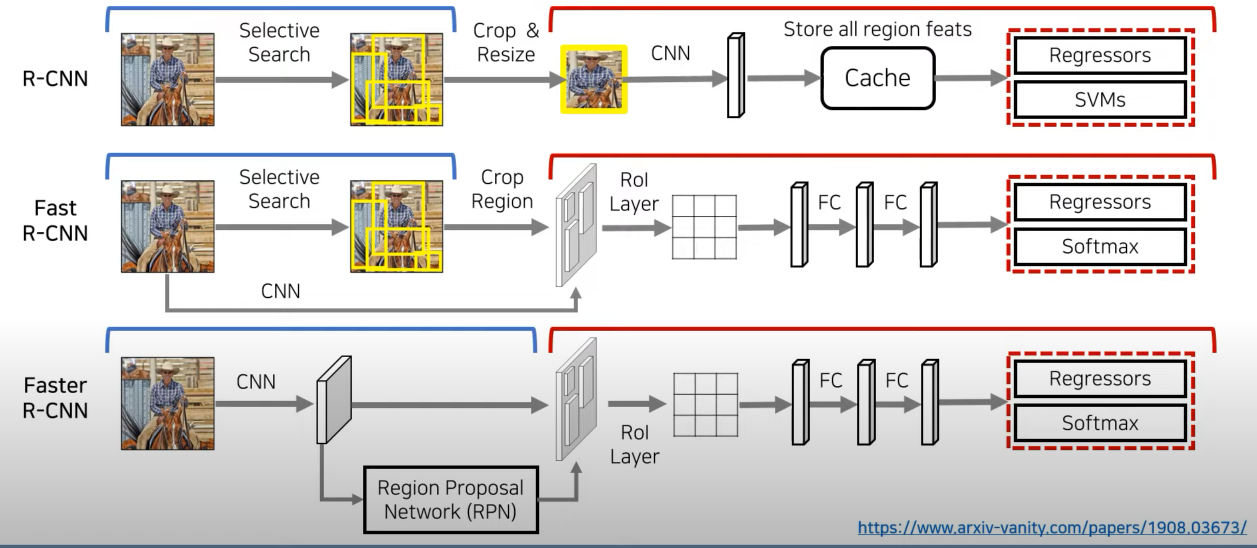

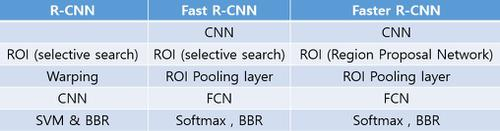

### 구조

* R-CNN의 기본적인 구조는 2-stage Detector
* 물체의 위치를 찾는 Region Proposal, 그리고 물체를 분류하는 Region Classification의 두 단계의 task를 가진다.

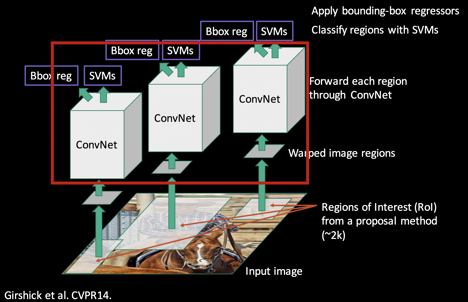

### 절차

#### 1. image Input

#### 2. Region proposal
* Selective search 알고리즘을 통해 ROI를 2000 여 개 정도의 Region을 뽑아내어 bounding box를 생성

* **Selective search 알고리즘**
    - Segmentation 분야에 많이 쓰이는 알고리즘
    - 객체와 주변간의 색감(Color), 질감(Texture) 차이, 다른 물체에 애워쌓여있는지(Enclosed) 여부 등을 파악해서 다양한 전략으로 물체의 위치를 파악할 수 있도록 하는 알고리즘
    -  Bounding box들을 Random 하게 많이 생성을하고 이들을 조금씩 Merge 해나가면서 물체를 인식해나가는 방식
    
    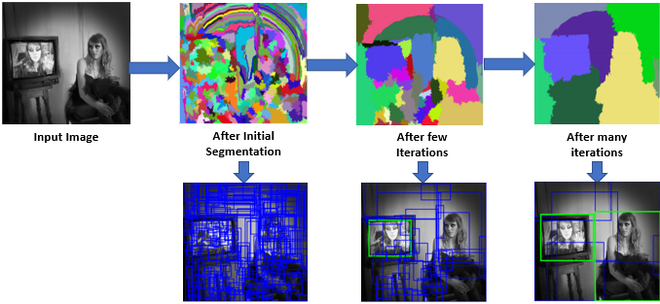

#### 3. Warping
* CNN에 넣기 전에 같은 사이즈(227 x 227)로 warping 해야 한다.
* bounding box 크기의 비율은 고려하지 않고 일률적으로 같은 사이즈로 만들기 때문에 이 과정에서 input image가 왜곡되고 정보가 소실되는 현상이 발생

#### 4. CNN feature extract
* 3의 Warping과정을 통해 크기가 조절된 Bounding box를 CNN 모델에 넣는다.

#### 5. Image Classification with SVM (Support Vector Machine)
* CNN을 통해 추출한 벡터를 가지고 각각의 클래스 별로 SVM Classifier를 학습시킨다.
* SVM Classification을 한 후의 2000여개의 bounding box들은 어떤 물체일 확률 값을 갖게 된다.

#### 6. Non-Maximum Suppression
* 2000여개의 bounding box는 어떤 객체일 확률 값을 갖게 되었지만 이 박스를 모두 사용하지 않는다.
* 동일 물체에 여러 개의 bounding box가 설정되는 경우가 있기 때문
* Non-Maximum Suppression을 통해 객체 전체를 대상화할 수 있는 bounding box 한 개를 선택

#### 7. Bounding box regression (BBR)
* Selective Search로 찾은 Bounding Box 위치가 부정확하기에 Bounding Box Regression을 시행
* bounding box 위치 선정을 교정하고 모델의 성능을 높이기 위한 과정
* Ground Truth, G 와 초기 Bounding Box, P의 위치는 중심점 좌표 (x,y)와 box의 크기 (width, height)를 결합하여 표시할 수 있다.
* P (x,y,w,h)가 input으로 들어왔을 때 이를 이동시켜 G를 잘 예측하는 것이 목표
* dx, dy, exp(dw), exp(dh) 를 각각 곱하여 예측치 G_hat을 만든다.
* d 함수는 P를 G_hat으로 이동시키기 위해서 필요한 이동량을 의미, BBR에서 학습시키는 것은 이 d함수이다.
* t 함수는 P를 G로 이동시키기 위해서 필요한 이동량을 의미, d함수와 형태는 동일

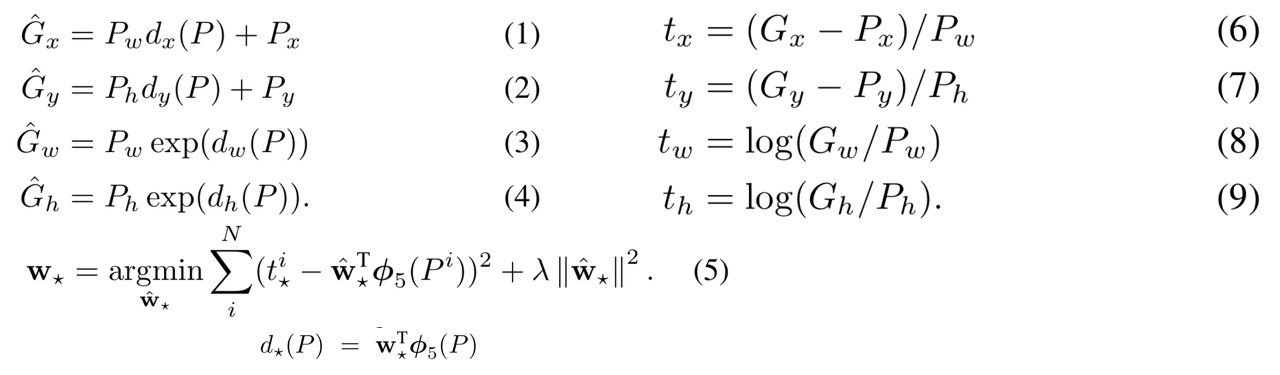

### 단점
* AlexNet을 그대로 사용하기위해 image를 강제로 변형 시켜야 함
* warping 하는 과정에서 input 이미지가 왜곡되고 정보 손실이 발생
* Selective Search를 통해 뽑힌 2000개의 Region proposal 후보를 모두 CNN에 집어넣기 때문에 training / testing 시간이 오래 걸림
* Selective Search나 SVM이 GPU에 적합한 구조가 아니다.
* Computation sharing이 일어나지 않는다. (CNN, SVM, Bounding Box Regression 총 세 가지의 모델이 결합된 형태로 한 번에 학습이 불가능합니다. 즉, end-to-end 훈련이 불가능하다는 뜻. SVM, Bounding Box Regression을 학습시켜도 Back propagation이 안되므로 CNN은 업데이트 되지 않는다.)